In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for cluster analysis
from sklearn.cluster import KMeans

# for PCA - Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram,linkage
%matplotlib inline

#Let's read UseArrests.csv

df = pd.read_csv("UsArrests.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [10]:
# checking city column for unexpected/missing values and any misspellings
city_un = df['City'].unique()
city_un.sort()
city_un

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [11]:
# checking murder column for unexpected values

murder_un = df['Murder'].unique()
murder_un.sort()
murder_un

array([ 0.8,  2.1,  2.2,  2.6,  2.7,  3.2,  3.3,  3.4,  3.8,  4. ,  4.3,
        4.4,  4.9,  5.3,  5.7,  5.9,  6. ,  6.3,  6.6,  6.8,  7.2,  7.3,
        7.4,  7.9,  8.1,  8.5,  8.8,  9. ,  9.7, 10. , 10.4, 11.1, 11.3,
       11.4, 12.1, 12.2, 12.7, 13. , 13.2, 14.4, 15.4, 16.1, 17.4])

# Duplicate Rows

Although there are 50 states ('cities' means 'states' here) and 50 rows it's unlikely that there are any duplicate rows, but worth checking anyway.

In [12]:
duplicates = df[df.duplicated()]
print("Duplicated Rows")
duplicates

Duplicated Rows


,City,Murder,Assault,UrbanPop,Rape


# Changing Dtypes

'City' is in an object dtypes so I'm going to change this to string. I am also going to change the name of this column to 'State' as it has been misnamed in this df, and the change helps me keep in mind what I'm measuring.

In [13]:
#changing dtype to string

df['City'] = df['City'].astype('string')

# confirming that the change worked
print(type(df['City'][0]))

# Renaming the 'City' column to 'State'

df.rename(columns={'City':'State'})

<class 'str'>


# Data Distribution and Outliers
Below I'm going to get some basic information about the data and check some outliers using box-plot

In [15]:

df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


This dataset is looking at arrests per 100,000 residents, and 'UrbanPop' is the percent of the population living in Urban areas.

A look at very basic descriptive statistics tells us that the highest arrest rate for a crime is for assault (which is considerably higher than the others), followed by rape and murder. A high std deviation for assault denotes high variation in the dataset for thes variable, and a low std deviation for murder denotes much less variation (i.e. it's unlikely any given stated has many more or fewer arrests per 100,000 people for murder than 7). I'm going to make a histogram as well to see how the data is distributed when visualised.

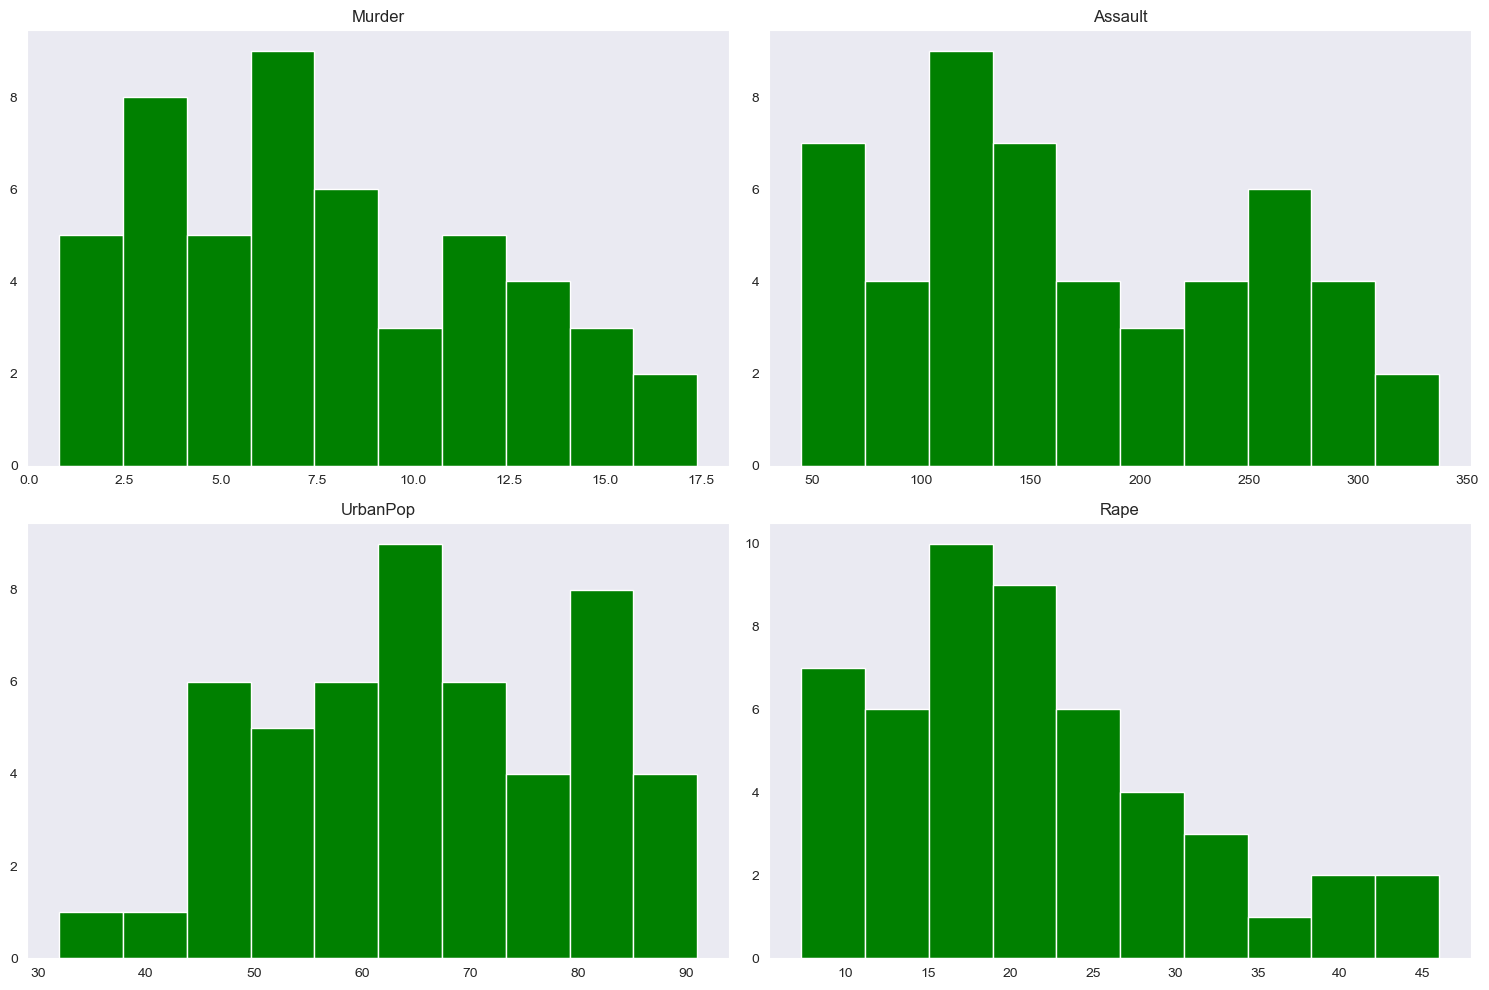

In [18]:
# Plotting  Histograms

histograms = df.hist(color="green",grid=False, figsize=(15,10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()


The arrest rate distribution for both murder and assault is bimodal (with a second small peak for the rape histogram, though it's so small I would call this unimodal). This suggests that the datapoints can be split into 2 groups, which I will explore in the cluster analyses. The UrbanPop fits a more normal unimodal distribution.

Of interest is the rape histogram - the frequency on the y-axis for the other graphs only goes up to 8, whereas for rape it goes up to 20. At least 20 states have an arrest rate of 15-20 per 100,000 for rape. Additionall, the graph is leptokurtic (high kurtosis, heavy tail), meaning 1) it's more concentrated around the mean than the other graphs and 2) there are likely to be outliers. I will explore this using boxplots below.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1d8a60e80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1bc906310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1d8a607f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1bc906a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1bc92a760>],
 'means': []}

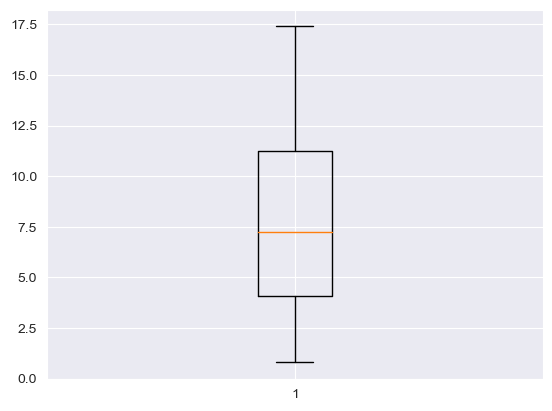

In [23]:
x = df['Murder']
plt.boxplot(x)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1d8803af0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1cad386a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1d88039a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1cad381c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1cad63c40>],
 'means': []}

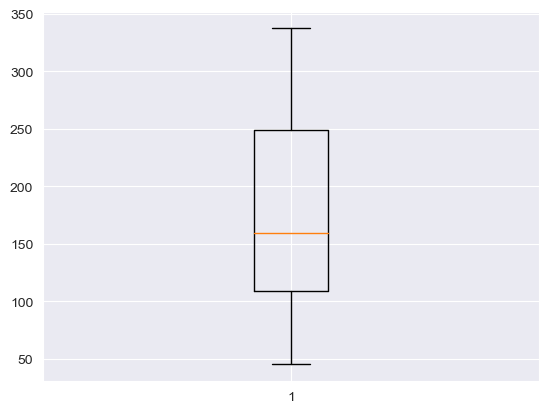

In [24]:
x = df.Assault
plt.boxplot(x)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe178602b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1785fd040>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1786026a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1785fd580>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe178605550>],
 'means': []}

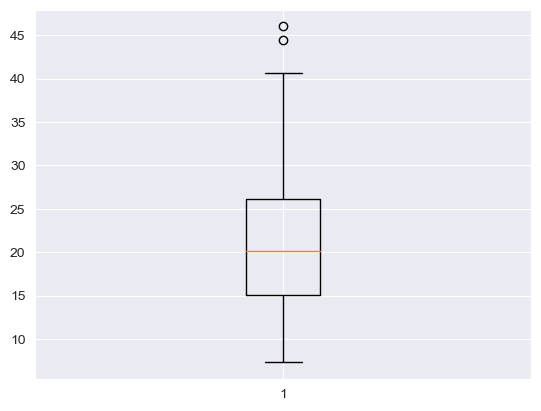

In [25]:
x = df.Rape
plt.boxplot(x)